In [1]:
__author__ = 'Yumi Choi <yumi.choi@noirlab.edu>'
__version__ = '20240213' 
__datasets__ = ['phat_v2']  
__keywords__ = ['M31', 'stars', 'plot:cmd', 'plot:sed', 'interactive plot']

# Exploring Resolved Stellar Populations in M31 with PHAT

*Yumi Choi & the Astro Data Lab Team*

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Explore the main PHAT object table](#exploreTable)
* [Make Healpix maps of the brick number, MS and RGB stars](#chapter1)
* [Variation in stellar populations and photometric quality across M31's disk](#chapter2)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
* Learn how to use an SQL query to make Healpix maps of PHAT brick number as well as young and old stellar populations 
* Learn how to retrieve data for each brick and plot color-magnitude diagrams and broad-band spectral energy distribution for individual stars
* Explore how stellar populations and photometry quality vary across M31's disk

# Summary
Our own galaxy, the Milky Way (MW), provides detailed views of astrophysical processes, anchoring much of our understanding about galaxy formation and evolution. However, because we are observing the MW while residing in it, our observations suffer from complications arising from line-of-sight reddening, uncertain distances, and background/foreground confusion. Studying external galaxies instead, which are free of these projection effects, offers a much cleaner view of an entire galaxy. The closest massive galaxy to the MW, the Andromeda galaxy (also known as M31) provides a superb laboratory, as its proximity still allows us to resolve its individual stars but is far enough away to observe the entire galaxy. Furthermore, M31 contains a wide range of local environments consisting of young and old stellar populations. It also has various structures including spiral arms, star-forming rings, a bar, and a bulge. 

The Panchromatic Hubble Andromeda Treasury (<a href="http://adsabs.harvard.edu/abs/2012ApJS..200...18D">PHAT</a>; PI Dalcanton) was a Hubble Space Telescope Multi-cycle program to map roughly a third of M31's star forming disk, using 6 filters covering wavelengths from the ultraviolet through the near infrared. 


<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass
from itertools import cycle

# 3rd party # remove imports that are not needed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import healpy as hp
import random

# Data Lab
from dl import authClient as ac, queryClient as qc

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

<a class="anchor" id="exploreTable"></a>
# Explore the main PHAT object table
The notebook <a href="https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/ExploringM31/M31WithPhat.ipynb">M31withPhat.ipynb</a> listed available tables in the PHAT database. This notebook will use the main PHAT object table, phat_v2.phot_mod, which contains combined average photometry.

### Examine the columns of the phat_v2.phot_mod table

First, query 10 rows from phat_v2.phot_mod just to get some basic information about the table.

In [4]:
query = """SELECT *
           FROM phat_v2.phot_mod
           LIMIT 10
        """

Save the query result, which is by default a CSV formatted string, as a Pandas dataframe.

In [5]:
df = qc.query(sql=query, fmt='pandas')
print("Number of columns:",len(df.columns))
print("List of columns:", df.columns)
df

Number of columns: 92
List of columns: Index(['ra', 'dec', 'elon', 'elat', 'glon', 'glat', 'field', 'brick', 'x', 'y',
       'f110w_rate', 'f110w_raterr', 'f110w_vega', 'f110w_err', 'f110w_chi',
       'f110w_snr', 'f110w_sharp', 'f110w_round', 'f110w_crowd', 'f160w_rate',
       'f160w_raterr', 'f160w_vega', 'f160w_err', 'f160w_chi', 'f160w_snr',
       'f160w_sharp', 'f160w_round', 'f160w_crowd', 'f275w_rate',
       'f275w_raterr', 'f275w_vega', 'f275w_err', 'f275w_chi', 'f275w_snr',
       'f275w_sharp', 'f275w_round', 'f275w_crowd', 'f336w_rate',
       'f336w_raterr', 'f336w_vega', 'f336w_err', 'f336w_chi', 'f336w_snr',
       'f336w_sharp', 'f336w_round', 'f336w_crowd', 'f475w_rate',
       'f475w_raterr', 'f475w_vega', 'f475w_err', 'f475w_chi', 'f475w_snr',
       'f475w_sharp', 'f475w_round', 'f475w_crowd', 'f814w_rate',
       'f814w_raterr', 'f814w_vega', 'f814w_err', 'f814w_chi', 'f814w_snr',
       'f814w_sharp', 'f814w_round', 'f814w_crowd', 'ir_x', 'ir_y',
       'f814w

,ra,dec,elon,elat,glon,glat,field,brick,x,y,...,f814w_gst,f110w_gst,f160w_gst,f110w_flag,f160w_flag,f275w_flag,f336w_flag,f475w_flag,f814w_flag,objid
0,11.009753,41.461045,28.215074,33.404431,121.443283,-21.389316,1,5,756.36,1797.46,...,1,1,0,0,0,0,0,0,0,PHAT_11.0097529+41.461045
1,11.009689,41.461069,28.215037,33.404475,121.443232,-21.389290,1,5,753.50,1800.06,...,1,0,0,0,0,0,0,2,0,PHAT_11.0096890+41.461069
2,11.009760,41.461075,28.215097,33.404455,121.443290,-21.389286,1,5,754.49,1796.32,...,1,1,1,0,0,0,0,0,0,PHAT_11.0097603+41.461075
3,11.009727,41.461087,28.215078,33.404478,121.443264,-21.389273,1,5,753.00,1797.66,...,1,1,0,0,0,0,0,0,0,PHAT_11.0097272+41.461087
4,11.009374,41.461133,28.214823,33.404642,121.442981,-21.389219,1,5,743.14,1814.32,...,0,1,0,0,0,0,0,0,2,PHAT_11.0093736+41.461133
5,11.009383,41.461152,28.214841,33.404656,121.442989,-21.389200,1,5,742.02,1813.36,...,1,0,0,0,0,0,0,0,0,PHAT_11.0093828+41.461152
6,11.009544,41.461166,28.214976,33.404612,121.443118,-21.389189,1,5,744.15,1804.89,...,1,0,0,0,0,0,0,0,0,PHAT_11.0095435+41.461166
7,11.009573,41.461138,28.214984,33.404577,121.443141,-21.389218,1,5,746.59,1804.14,...,1,0,0,0,0,0,0,0,0,PHAT_11.0095727+41.461138
8,11.009596,41.461149,28.215008,33.404579,121.443160,-21.389208,1,5,746.32,1802.68,...,0,1,0,0,0,0,0,2,0,PHAT_11.0095962+41.461149
9,11.009745,41.461102,28.215100,33.404485,121.443278,-21.389258,1,5,752.34,1796.39,...,1,1,1,0,0,0,2,0,0,PHAT_11.0097448+41.461102


<a class="anchor" id="chapter1"></a>
# Make Healpix maps of the brick number, main sequence (MS) and red giant branch (RGB) stars

PHAT tiled the survey area with 23 bricks. Each brick consists of a 3$\times$6 mosaic of 18 HST pointings (<a href="http://adsabs.harvard.edu/abs/2012ApJS..200...18D">Dalcanton et al. (2012)</a>).

One of the columns in the PHAT object table, nest4096, is the Healpix index (NSIDE=4096, nested scheme) for the object's RA and Dec. Healpix is a handy tesselation of the sky into tiles of equal area. To make maps of aggregate quantities in PHAT, we're going to use the database to return results in a query grouped by Healpix index value.  We can then put the results into arrays, and use `healpy`'s functionality to display the maps.

In this first query, the GROUP BY clause tells the database to aggregate the results by the values in the nest4096 column, and return the average RA and Dec of objects in those groups, as well as the nest4096 value itself and the count of the number of objects in the group. Here we only retrieve blue and relatively bright MS stars with good photometric quality. The color and magnitude selection criteria for MS and RGB stars are motivated by Figure 18 in <a href="https://ui.adsabs.harvard.edu/abs/2023ApJS..268...48W">Williams et al. (2023)</a>. 

In [6]:
query = """SELECT avg(ra) as ra0, avg(dec) as dec0, nest4096, count(nest4096) as nb, 
            avg(brick) as brick
           FROM phat_v2.phot_mod
           WHERE f475w_gst=1 AND f814w_gst=1 AND 
            f475w_vega-f814w_vega>-0.5 AND f475w_vega-f814w_vega<0.25 AND f814w_vega<24
           GROUP BY nest4096
          """

Save the query result of MS stars as a Pandas dataframe.

In [7]:
df_MS = qc.query(sql=query, fmt='pandas')
print("Number of rows:", len(df_MS))

Number of rows: 2381


Compute the center of the RA and Dec distribution of the objects

In [8]:
rarot, decrot = np.median(df_MS['ra0']), np.median(df_MS['dec0'])

### Healpix map of the PHAT brick number

This map will later serve to denote locations with varying stellar density within the disk.

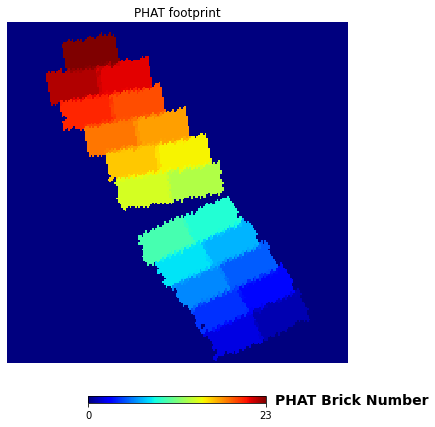

In [9]:
brickmap = np.zeros(hp.nside2npix(4096))
brickmap[df_MS['nest4096']] = df_MS['brick']
hp.gnomview(brickmap, title='PHAT footprint', reso=0.4, nest=True, 
            rot=(rarot,decrot,0), notext=True, cmap='jet', unit='PHAT Brick Number')

### Healpix map of MS stars

We are now plotting the distribution of MS stars in M31.

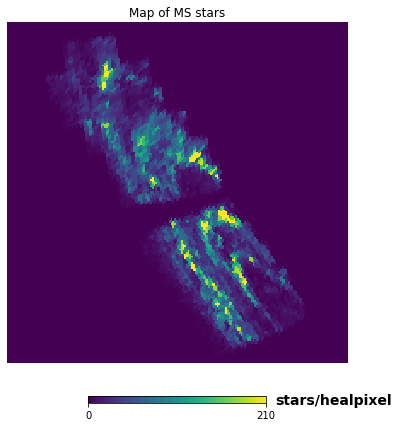

In [10]:
msmap = np.zeros(hp.nside2npix(4096))
msmap[df_MS['nest4096']] = df_MS['nb']
nmax = 0.5*msmap.max() # set the maximum range value to the half of the maximum value of the map to improve visualization
hp.gnomview(msmap, title='Map of MS stars', notext=True, reso=0.4, nest=True, 
            rot=(rarot,decrot,0), unit='stars/healpixel', max=nmax)

Young MS stars are clearly clustered around the spiral arms and the 10 kpc ring, where active recent star formation takes place. 

### Healpix map of RGB stars

The same query as above, but for RGB stars with good photometry quality.

In [11]:
query = """SELECT nest4096, count(nest4096) as nb
           FROM phat_v2.phot_mod
           WHERE f110w_gst=1 AND f160w_gst=1 AND 
            f110w_vega-f160w_vega>0.75 AND f110w_vega-f160w_vega<2.0 AND 
            f160w_vega>18.5 AND f160w_vega<22.0
           GROUP BY nest4096
          """

Save the query result as a Pandas dataframe.

In [12]:
df_RGB = qc.query(sql=query, fmt='pandas')
print("Number of rows:", len(df_RGB))

Number of rows: 2449


We are now plotting the distribution of RGB stars in M31.

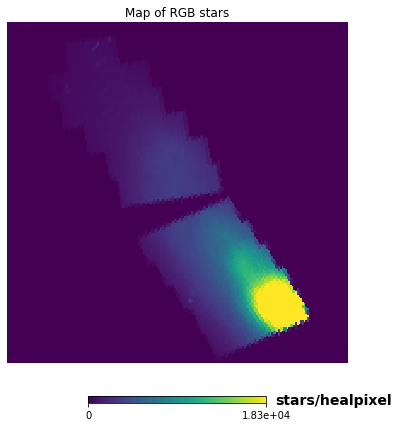

In [13]:
rgbmap = np.zeros(hp.nside2npix(4096))
rgbmap[df_RGB['nest4096']] = df_RGB['nb']
nmax = 0.5*rgbmap.max() # set the maximum range value to the half of the maximum value of the map to improve visualization
hp.gnomview(rgbmap, title='Map of RGB stars', notext=True, reso=0.4, nest=True, 
            rot=(rarot,decrot,0), unit='stars/healpixel', max=nmax)

Contrary to MS stars, old RGB stars show a smoother spatial distribution, mainly following a stellar density profile described as a combination of an exponential disk and a bulge.

<a class="anchor" id="chapter2"></a>
# Variation in stellar populations and photometric quality across M31's disk

As seen in the maps of MS and RGB stars above, the spatial distribution of stellar populations as well as the stellar number density vary with their position within the galaxy disk. The number density of RGB stars, which are dominant by number, increases towards the center of M31. The stellar "crowding" becomes the dominant source of error in the HST photometry. The rest of the notebook will explore how stellar populations and photometric quality change with position within the disk by looking at multiple color-magnitude diagrams (CMDs) in representative environments (Bricks 1, 15, and 23). We will also plot stellar broad-band spectral energy distributions (SEDs) for randomly selected stars in each environment. 

## Do query for Brick 1 (most crowded central region)

In [14]:
query = """SELECT f275w_vega, f336w_vega, f475w_vega, f814w_vega, f110w_vega, f160w_vega 
           FROM phat_v2.phot_mod
           WHERE f275w_gst=1 AND f336w_gst=1 AND 
                 f475w_gst=1 AND f814w_gst=1 AND 
                 f110w_gst=1 AND f160w_gst=1 AND
                 brick=1
          """

Save the query result as a Pandas dateframe.

In [15]:
df_b1 = qc.query(sql=query, fmt='pandas')
print("Number of rows:", len(df_b1))

Number of rows: 1141400


### Make UV, optical, and IR CMDs for Brick 1

Young and massive stars are dominant sources of UV photons, while old and cool stars are dominant sources of IR photons. Most stellar populations emit a good amount of optical photons unless they are heavily embedded in dust. Here, the UV CMD highlights mostly young stars, the optical CMD features mostly all stellar populations, and the IR CMD highlights mostly more evolved cool stars.

Let's define a function to plot UV, optical, and IR CMDs for a given Brick table.

In [16]:
def make_cmds(brick, starlist=None):
    """
    brick: Pandas dataframe for a given PHAT Brick
    starlist: list of indices for stars (default=None)
    cmap: color map (default='gray_r')
    """
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
    if starlist is None:
        cmap = plt.cm.viridis
    else:
        cmap = plt.cm.gray_r
    
    def plot_panel(ax, x, y, range_=None, xlabel='', ylabel='', title='', starlist=None):    
        h = ax.hist2d(x, y, bins=200, range=range_, cmap=cmap, norm=plt.matplotlib.colors.LogNorm())
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        ax.set_xlim(h[1].min()-0.5, h[1].max()+0.5)
        ax.set_ylim(h[2].max()+1, h[2].min()-1)
        ax.set_title(title, fontsize=20)
        if starlist is not None:
            colors = cycle(mcolors.TABLEAU_COLORS)  # recurring cycle of defined plot colors
            ax.scatter(x[starlist], y[starlist], s=50, c=[next(colors) for j in range(len(starlist))])
    
    plot_panel(ax1,brick['f275w_vega']-brick['f336w_vega'],brick['f336w_vega'],((-2,4),(15,27)),'F275W - F336W','F336W','UV CMD',starlist=starlist)
    plot_panel(ax2,brick['f475w_vega']-brick['f814w_vega'],brick['f814w_vega'],((-1,6),(14,29)),'F475W - F814W','F814W','Optical CMD',starlist=starlist)
    plot_panel(ax3,brick['f110w_vega']-brick['f160w_vega'],brick['f160w_vega'],((-1,3),(11,28)),'F110W - F160W','F160W','IR CMD',starlist=starlist)

    plt.show()

Since Brick 1 covers the innermost region of M31, this region suffers the most from stellar crowding. The effect of crowding on the photometry quality is shown as broadening of the features and shallow depth in each CMD.

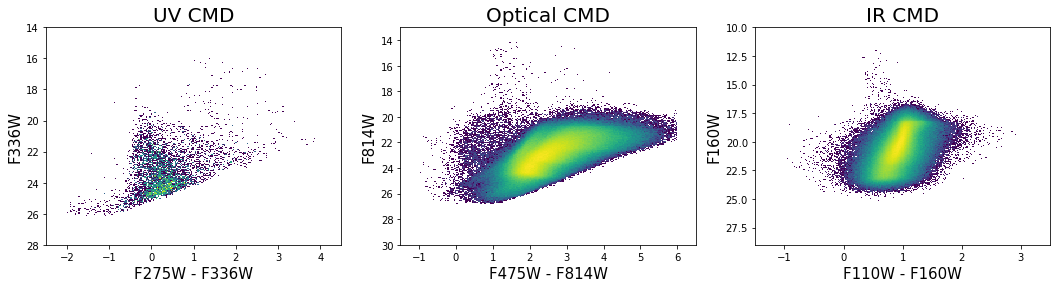

In [17]:
make_cmds(df_b1)

### Plot a broad-band spectral energy distribution of selected stars in Brick 1

First, let's define the pivot wavelengths for the PHAT filters (from the __[HST Instrument Handbooks](https://hst-docs.stsci.edu/hom)__).

In [18]:
# Pivot wavelength in nm for each filter (F275W, F336W, F475W, F814W, F110W, F160W)
plambda = [270.97, 335.45, 474.44, 805.98, 1153.4, 1536.9]

Define a function to select stars, in a given Brick, that have good photometry in all 6 bands.

In [19]:
def good_stars(brick):
    stars_6b, = np.where((brick['f275w_vega'] < 30) & (brick['f336w_vega'] < 30) &
                         (brick['f475w_vega'] < 30) & (brick['f814w_vega'] < 30) & 
                         (brick['f110w_vega'] < 30) & (brick['f160w_vega'] < 30))
    print('There are %d stars with good measurements in all 6 bands!' % (len(stars_6b))) 
    
    return stars_6b

Define a function to pick random three stars out of the sample with good 6-band photomery, plot their broad-band SEDs, and indicate their positions in each of UV, optical, and IR CMDs. 

In [20]:
def make_seds(brick, k=3):
    """
    brick: Pandas dataframe for a given PHAT Brick
    k: number of random stars to select (default=3)
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    stars_6b = good_stars(brick)
    sIDs = random.choices(stars_6b, k=k)
    c = cycle(mcolors.TABLEAU_COLORS)  # recurring cycle of defined plot colors
    for j,i in enumerate(sIDs):
        ax.plot(plambda, [brick['f275w_vega'][i], brick['f336w_vega'][i], 
                          brick['f475w_vega'][i], brick['f814w_vega'][i],
                          brick['f110w_vega'][i], brick['f160w_vega'][i]], marker='.', ls='-', c=next(c))
    ymin = np.min(brick.iloc[sIDs].values.ravel())
    ymax = np.max(brick.iloc[sIDs].values.ravel())
    ax.set_ylim(ymax+0.5, ymin-0.5)
    ax.set_xlabel(r'$\lambda$ [nm]',fontsize=15)
    ax.set_ylabel('magnitude',fontsize=15)

    make_cmds(brick, starlist=sIDs)

    plt.show()

Pick random three stars out of the sample with good 6-band photomery, and plot their broad-band SEDs and indicate their positions in each CMD. 

There are 4909 stars with good measurements in all 6 bands!


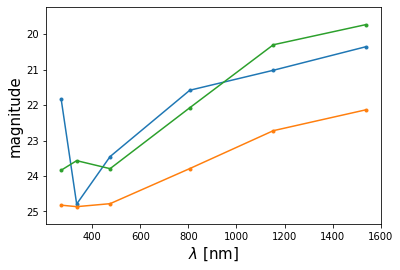

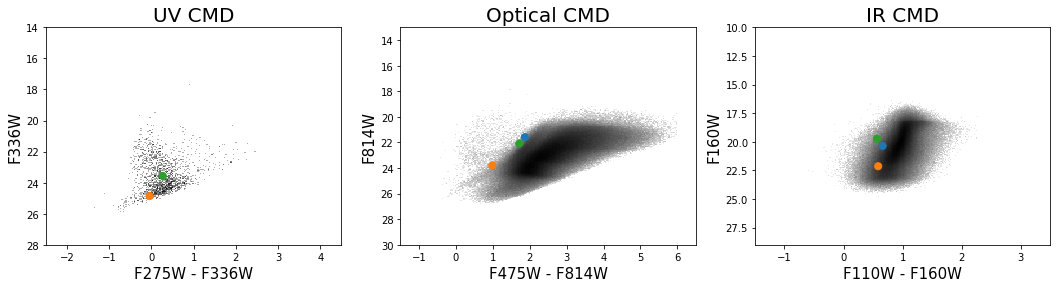

In [21]:
make_seds(df_b1, k=3)

## Do query for Brick 15 (10 kpc star-forming ring region)

Brick 15 covers a portion of the 10 kpc star-forming ring in M31's disk. This region suffers less from stellar crowding than Brick 1, and thus has deeper CMDs. However, the presence of more dust significantly extinguishes stars, making the CMD features fainter and broader due to dust extinction and reddening. 

In [22]:
query = """SELECT f275w_vega, f336w_vega, f475w_vega, f814w_vega, f110w_vega, f160w_vega 
           FROM phat_v2.phot_mod
           WHERE f275w_gst=1 AND f336w_gst=1 AND 
                 f475w_gst=1 AND f814w_gst=1 AND 
                 f110w_gst=1 AND f160w_gst=1 AND
                 brick=15
          """

Save the query result as a Pandas dataframe.

In [23]:
df_b15 = qc.query(sql=query, fmt='pandas')
print("Number of rows:", len(df_b15))

Number of rows: 658617


### Make UV, optical, and IR CMDs for Brick 15

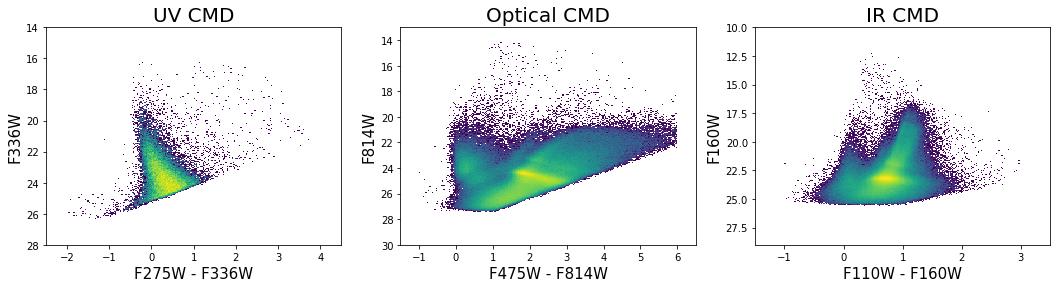

In [24]:
make_cmds(df_b15)

Pick random three stars out of the sample with good 6-band photomery, and plot their broad-band SEDs and indicate their positions in each CMD. 

There are 31723 stars with good measurements in all 6 bands!


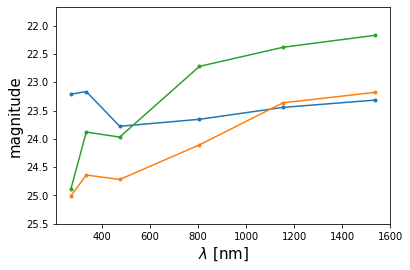

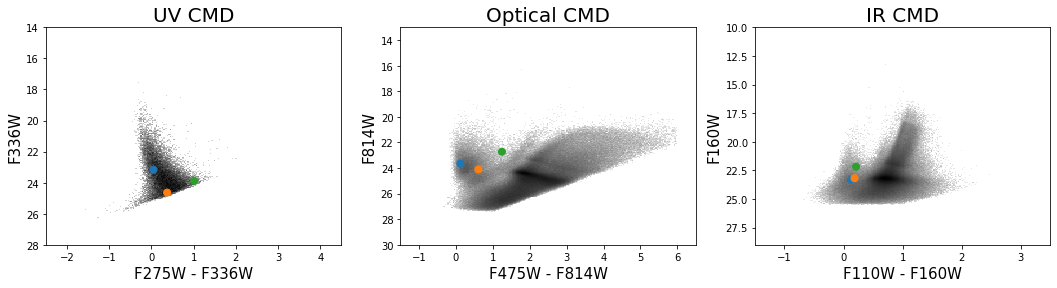

In [25]:
make_seds(df_b15, k=3)

## Do query for Brick 23 (outer most low-density region)

Brick 23 covers the outer most star-forming disk. Therefore, we expect to see prominent young MS stars. In addition, the least effect of stellar crowding and less effect of dust are expected compared to Bricks 1 and 15. These all together allows for Brick 23 to achieve the deepest and sharpest CMDs within the PHAT footprint. 

In [26]:
query = """SELECT f275w_vega, f336w_vega, f475w_vega, f814w_vega, f110w_vega, f160w_vega
           FROM phat_v2.phot_mod
           WHERE f275w_gst=1 AND f336w_gst=1 AND 
                 f475w_gst=1 AND f814w_gst=1 AND 
                 f110w_gst=1 AND f160w_gst=1 AND
                 brick=23
          """

Save the query result as a Pandas dataframe.

In [27]:
df_b23 = qc.query(sql=query, fmt='pandas')
print("Number of rows:", len(df_b23))

Number of rows: 253181


### Make UV, optical, and IR CMDs for Brick 23

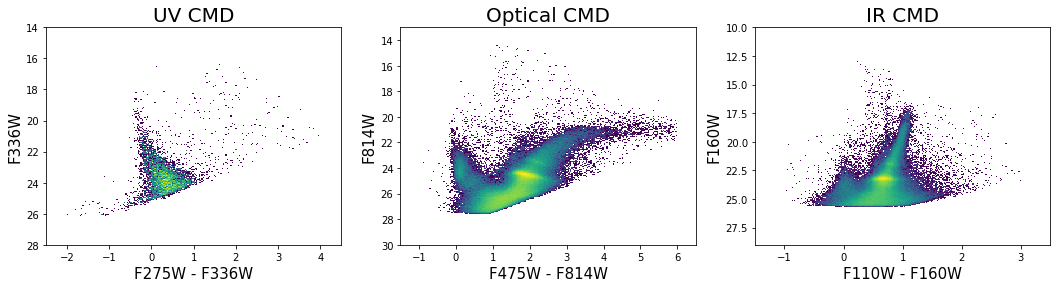

In [28]:
make_cmds(df_b23)

Pick random three stars out of the sample with good 6-band photomery, and plot their broad-band SEDs and indicate their positions in each CMD. 

There are 6281 stars with good measurements in all 6 bands!


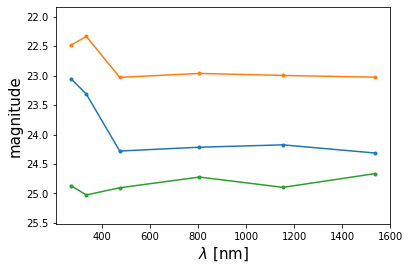

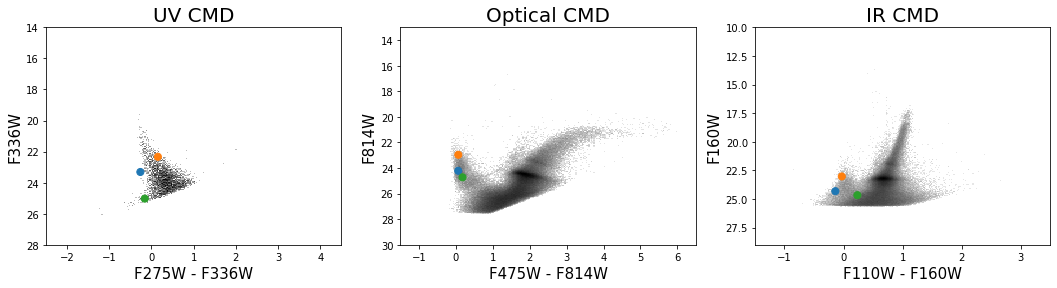

In [29]:
make_seds(df_b23, k=3)

<a class="anchor" id="resources"></a>
# Resources and references
Dalcanton, J.J. et al. (2012, ApJS, 200, 18), "The Panchromatic Hubble Andromeda Treasury"
http://adsabs.harvard.edu/abs/2012ApJS..200...18D

Williams, B.F. et al. (2018, ApJS, 236, 4), "Reducing and Analyzing the PHAT Survey with the Cloud"
https://ui.adsabs.harvard.edu/abs/2018ApJS..236....4W

Williams, B.F. et al. (2023, ApJS, 268, 48), "The Panchromatic Hubble Andromeda Treasury XXI. The Legacy Resolved Stellar Photometry Catalog"
https://ui.adsabs.harvard.edu/abs/2023ApJS..268...48W